In [1]:
import numpy as np
import json
import torch
from pprint import pprint

from hnet.models.mixer_seq import HNetForCausalLM
from hnet.models.config_hnet import (
    AttnConfig,
    SSMConfig,
    HNetConfig,
)

model_config_path = "configs/hnet_1stage_L.json"

In [2]:
with open(model_config_path, "r") as f:
    config = json.load(f)

# Create config objects
attn_cfg = AttnConfig(**config.pop("attn_cfg"))
ssm_cfg = SSMConfig(**config.pop("ssm_cfg"))
hnet_cfg = HNetConfig(**config, attn_cfg=attn_cfg, ssm_cfg=ssm_cfg)
print(attn_cfg)
print(ssm_cfg)
pprint(hnet_cfg)

AttnConfig(num_heads=[16, 16], rotary_emb_dim=[32, 48], window_size=[1023, -1])
SSMConfig(d_conv=4, expand=2, d_state=128, chunk_size=256)
HNetConfig(arch_layout=['m4', ['T22'], 'm4'],
           d_model=[1024, 1536],
           d_intermediate=[0, 4096],
           vocab_size=256,
           ssm_cfg=SSMConfig(d_conv=4, expand=2, d_state=128, chunk_size=256),
           attn_cfg=AttnConfig(num_heads=[16, 16],
                               rotary_emb_dim=[32, 48],
                               window_size=[1023, -1]),
           tie_embeddings=False)


In [3]:
# Create model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = HNetForCausalLM(hnet_cfg, device=device, dtype=torch.bfloat16)
model

HNetForCausalLM(
  (embeddings): Embedding(256, 1024)
  (backbone): HNet(
    (encoder): Isotropic(
      (layers): ModuleList(
        (0-3): 4 x Block(
          (norm1): RMSNorm()
          (mixer): Mamba2Wrapper(
            (in_proj): Linear(in_features=1024, out_features=4384, bias=False)
            (conv1d): Conv1d(2304, 2304, kernel_size=(4,), stride=(1,), padding=(3,), groups=2304)
            (act): SiLU()
            (norm): RMSNorm()
            (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
          )
        )
      )
      (rmsnorm): RMSNorm()
    )
    (main_network): HNet(
      (main_network): Isotropic(
        (layers): ModuleList(
          (0-21): 22 x Block(
            (norm1): RMSNorm()
            (mixer): CausalMHA(
              (rotary_emb): RotaryEmbedding()
              (Wqkv): Linear(in_features=1536, out_features=4608, bias=False)
              (inner_attn): FlashCausalSelfAttention()
              (inner_cross_attn): FlashCausal

In [4]:
# Calculate number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params / 1e6:.2f}M")

Total number of parameters: 679.41M


In [5]:
# from hnet.utils.train import load_balancing_loss

# load_balancing_loss(routing_module, N=3)

In [6]:
from hnet.utils.tokenizers import ByteTokenizer

prompt = "Hello, my name is"

tokenizer = ByteTokenizer()
encoded = tokenizer.encode([prompt], add_bos=True)[0]
input_ids_BxL = torch.tensor(
    encoded["input_ids"], dtype=torch.long, device=device
).unsqueeze(0)
print(input_ids_BxL)
input_ids_BxL.shape

tensor([[254,  72, 101, 108, 108, 111,  44,  32, 109, 121,  32, 110,  97, 109,
         101,  32, 105, 115]], device='cuda:0')


torch.Size([1, 18])

In [7]:
mask = torch.ones(input_ids_BxL.shape, device=device, dtype=torch.bool)
output = model.forward(input_ids_BxL, mask=mask)
logits_BxLxV = output.logits
bpred = output.bpred_output

In [8]:
logits_BxLxV.shape

torch.Size([1, 18, 256])

In [9]:
bpred[0].boundary_prob

tensor([[[0.0000, 1.0000],
         [0.5078, 0.4902],
         [0.5508, 0.4492],
         [0.5352, 0.4648],
         [0.8633, 0.1367],
         [0.4922, 0.5078],
         [0.4844, 0.5156],
         [0.5312, 0.4668],
         [0.4961, 0.5039],
         [0.5078, 0.4902],
         [0.5156, 0.4844],
         [0.5156, 0.4863],
         [0.5156, 0.4824],
         [0.5273, 0.4727],
         [0.5000, 0.4980],
         [0.4766, 0.5234],
         [0.5156, 0.4824],
         [0.4961, 0.5039]]], device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<StackBackward0>)

In [10]:
probs_BxLxV = torch.softmax(logits_BxLxV, dim=-1)
probs_BxLxV.shape

torch.Size([1, 18, 256])

In [11]:
# DATASET PREPARATION
small_dataset = [
    "Hello, my name is Alice. I love programming in Python.",
    "The quick brown fox jumps over the lazy dog.",
    "Sleep Token is an English rock band formed in London in 2016.",
]

encoded_inputs = tokenizer.encode(small_dataset, add_bos=True, add_eos=True)
encoded_inputs_ids = [ids["input_ids"] for ids in encoded_inputs]
input_ids_list = [
    torch.tensor(ids, dtype=torch.long, device=device).unsqueeze(0)
    for ids in encoded_inputs_ids
]
print(input_ids_list)

[tensor([[254,  72, 101, 108, 108, 111,  44,  32, 109, 121,  32, 110,  97, 109,
         101,  32, 105, 115,  32,  65, 108, 105,  99, 101,  46,  32,  73,  32,
         108, 111, 118, 101,  32, 112, 114, 111, 103, 114,  97, 109, 109, 105,
         110, 103,  32, 105, 110,  32,  80, 121, 116, 104, 111, 110,  46, 255]],
       device='cuda:0'), tensor([[254,  84, 104, 101,  32, 113, 117, 105,  99, 107,  32,  98, 114, 111,
         119, 110,  32, 102, 111, 120,  32, 106, 117, 109, 112, 115,  32, 111,
         118, 101, 114,  32, 116, 104, 101,  32, 108,  97, 122, 121,  32, 100,
         111, 103,  46, 255]], device='cuda:0'), tensor([[254,  83, 108, 101, 101, 112,  32,  84, 111, 107, 101, 110,  32, 105,
         115,  32,  97, 110,  32,  69, 110, 103, 108, 105, 115, 104,  32, 114,
         111,  99, 107,  32,  98,  97, 110, 100,  32, 102, 111, 114, 109, 101,
         100,  32, 105, 110,  32,  76, 111, 110, 100, 111, 110,  32, 105, 110,
          32,  50,  48,  49,  54,  46, 255]], device='

In [17]:
from hnet.utils.train import load_balancing_loss
from tqdm import tqdm
from collections import defaultdict


ce_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model.train()

epochs = 30
n_experts = 2
lambda_lb_loss = 1.0

experiment_logs = {}

for epoch in tqdm(range(epochs), desc="Training Epochs"):
    experiment_logs[epoch] = defaultdict(list)
    for input_ids_BxL in input_ids_list:
        # Hardcoded batch size of 1
        optimizer.zero_grad()
        mask = torch.ones(input_ids_BxL.shape, device=device, dtype=torch.bool)
        output = model.forward(input_ids_BxL, mask=mask)
        logits_BxLxV: torch.Tensor = output.logits
        bpred = output.bpred_output[0]

        # explanation: predict next token, so we shift logits by one (truncate last)
        shift_logits = logits_BxLxV[:, :-1, :].contiguous()
        # we shift labels too, by one (truncate first)
        shift_labels = input_ids_BxL[:, 1:].contiguous()

        ce = ce_loss(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
        )

        lb_loss = load_balancing_loss(bpred, N=n_experts)
        loss = ce + lambda_lb_loss * lb_loss

        experiment_logs[epoch]["ce_loss"].append(ce.item())
        experiment_logs[epoch]["lb_loss"].append(lb_loss.item())
        experiment_logs[epoch]["total_loss"].append(loss.item())

        loss.backward()
        optimizer.step()

Training Epochs: 100%|██████████| 30/30 [00:13<00:00,  2.26it/s]


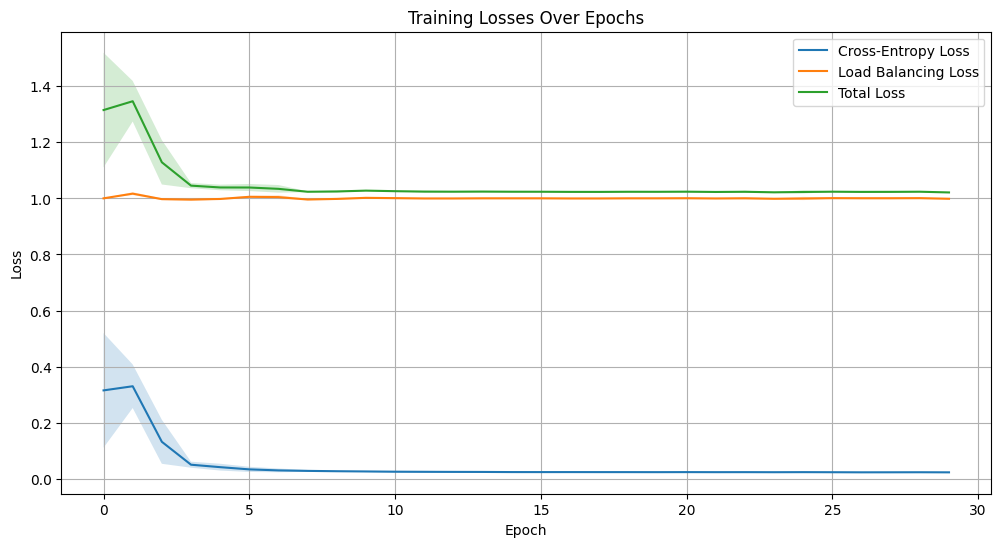

In [18]:
import matplotlib.pyplot as plt


def plot_experiment_logs(experiment_logs):
    epochs = list(experiment_logs.keys())
    ce_losses = [np.mean(experiment_logs[epoch]["ce_loss"]) for epoch in epochs]
    lb_losses = [np.mean(experiment_logs[epoch]["lb_loss"]) for epoch in epochs]
    total_losses = [np.mean(experiment_logs[epoch]["total_loss"]) for epoch in epochs]
    ce_losses_std = [np.std(experiment_logs[epoch]["ce_loss"]) for epoch in epochs]
    lb_losses_std = [np.std(experiment_logs[epoch]["lb_loss"]) for epoch in epochs]
    total_losses_std = [
        np.std(experiment_logs[epoch]["total_loss"]) for epoch in epochs
    ]

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, ce_losses, label="Cross-Entropy Loss")
    plt.fill_between(
        epochs,
        np.array(ce_losses) - np.array(ce_losses_std),
        np.array(ce_losses) + np.array(ce_losses_std),
        alpha=0.2,
    )
    plt.plot(epochs, lb_losses, label="Load Balancing Loss")
    plt.fill_between(
        epochs,
        np.array(lb_losses) - np.array(lb_losses_std),
        np.array(lb_losses) + np.array(lb_losses_std),
        alpha=0.2,
    )
    plt.plot(epochs, total_losses, label="Total Loss")
    plt.fill_between(
        epochs,
        np.array(total_losses) - np.array(total_losses_std),
        np.array(total_losses) + np.array(total_losses_std),
        alpha=0.2,
    )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Losses Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()


plot_experiment_logs(experiment_logs)

In [21]:
from generate import generate

generated_text = generate(
    model,
    prompt="Sleep Token is",
)

buf = []
token_count = 0
for token in generated_text:
    buf.append(token)
    token_count += 1

    decoded = None
    res = None
    for j in range(1, min(len(buf), 4)):
        try:
            res = tokenizer.decode(buf[:j])
            decoded = j
        except Exception:
            pass

    if res is not None:
        print(res, end="", flush=True)
        buf = buf[decoded:]

an English rock band formed in London in 2016